# Downloading products from GEE into netcdfs

Using package `wxee`: https://github.com/aazuspan/wxee

The default example loads `MODIS Terra thermal anomalies and Fire Daily`

> Note: Will likely need to install the two packages listed in the cell below. Uncomment, run the cell, then restart kernel.

## Load packages

In [ ]:
import os
import ee
import wxee
import geemap as gmap
import xarray as xr
import pandas as pd
import numpy as np

import rioxarray
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

## Authenticate GEE    

Need to sign up: https://earthengine.google.com/new_signup/

Then run the cell and follow the link/prompts

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

## Analysis parameters

Enter the product name and other parameters below, you find some of this info on the product data page, e.g. https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD14A1?hl=en

> Note: For the analysis extent try using http://geojson.io/ to draw a polygon, then copy and paste the coordinates into the cell

In [ ]:
product = "MODIS/006/MCD64A1"
bands =  ['BurnDate']
start_date = '1/1/2002'
end_date = '12/31/2021'
output_path = '/g/data/os22/chad_tmp/NEE_modelling/data/BurnDate/'
output_crs = "EPSG:3577"
resolution = 1000
scale = 0.0001

#~Aus region (slightly less to trick google into giving me 1km res)
region = ee.Geometry.Polygon([[
            [114,-43.0],
            [153.0,-43.0],
            [153.0,-10.0],
            [114,-10.0],
            [114,-43.0]]])


## Select region

In [ ]:
# Map = gmap.Map(basemap=gmap.basemaps['SATELLITE'], center=[-35.2041, 149.2721], zoom=8)
# Map

In [ ]:
region = Map.user_roi.getInfo()
region

## Loop through months and load MODIS data

Doing this on a per-month basis to keep the memory usage down

In [ ]:
#use start and end dates to loop through months and load GEE data
start = pd.date_range(start=start_date, end=end_date, freq='MS') 
end = pd.date_range(start=start_date, end=end_date, freq='M')

i = 0
for s, e in zip(start,end):
    print(" {:03}/{:03}\r".format(i+1, len(start)), end="")

    # use this to check if file already exists
    ss = s+pd.Timedelta(14, 'd')

    if os.path.isfile(output_path+product[-4:]+'_'+ss.strftime('%Y-%m')+'.nc'):
        pass
    
    else:
        try:
            s = s.strftime('%Y-%m-%d')
            e = e.strftime('%Y-%m-%d')
            
            #download data from GEE
            ts = wxee.TimeSeries(product).filterDate(s,e)
            ts = ts.select(bands)
            #print(ts)
            ds = ts.wx.to_xarray(region=region, scale=resolution, crs=output_crs, progress=False)
            #ds = ds[bands] * scale # scale values 
            attrs=ds.attrs #extract attributes so we don't loose them
            ds.attrs['nodata'] = np.nan
            ds = assign_crs(ds, crs=output_crs) #add geobox
            ds['time'] = ds.time + pd.Timedelta(14, 'd')
            #ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean() #resample to monthly

            evi = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/EVI_1km_monthly_2002_2021.nc').isel(time=0) #use this to reproject too
            ds = xr_reproject(ds, geobox=evi.geobox, resampling='nearest') #reproject
            ds['latitude'] = ds.latitude.astype('float32')
            ds['longitude'] = ds.longitude.astype('float32')
            ds = ds.where(~np.isnan(evi)).astype('float32')

#             #ds = ds.where(ds!=0) # remove spurious zeros from reprojection
            # ds = ds.assign_attrs(attrs) #add back attrs
            ds.to_netcdf(output_path+product[-4:]+'_'+np.datetime_as_string(ds.time.values[0], unit='M')+'.nc')
    
        except:
            print('fail:', s,e)
            pass
        
    i+=1

## Optional: Stitch together monthly files into annual netcdfs

Set the three parameters below

In [ ]:
year_start = 2002
year_end = 2021
annual_output_path = '/g/data/os22/chad_tmp/NEE_modelling/data/NDWI_annual/'

In [ ]:
i=0
for y in range(year_start, year_end+1):
    print(" {:02}/{:02}\r".format(i + 1, len(range(year_start, year_end+1))), end="")
    
    year = str(y)
    files = [output_path+f for f in os.listdir(output_path) if year in f]
    
    dss=[]
    for f in files:
        ds = xr.open_dataset(f)
        dss.append(ds)
        
    data = xr.concat(dss, dim='time').sortby('time')
    data = data.astype('float32')
    data['latitude'] = data.latitude.astype('float32')
    data['longitude'] = data.longitude.astype('float32')

    data.to_netcdf(annual_output_path+product[-8:]+'_'+year+'.nc')
    i+=1

In [ ]:
import os
import xarray as xr
import numpy as np

In [ ]:
rm -r -f /g/data/os22/chad_tmp/NEE_modelling/data/BurnDate/.ipynb_checkpoints

In [ ]:
base='/g/data/os22/chad_tmp/NEE_modelling/data/BurnDate/'
files = os.listdir(base)
ds = xr.open_mfdataset([base+f for f in files]).compute()
ds

Each year has a DOY value if it burnt
so 2013DOY, 2014DOY, 2015DOY etc.
What if I make Jan 2002 = 0, and Dec 2021 = 240 then can I work out the months-since-last-burn?

Would first need to turn DOY into a simple 1=burn, 0=noburn for each mont

	Any location where fires occurred within the last 10 years labelled as “fire-scar”. Fire scares are annually updated and after 10 years it was assumed had recovered

In [ ]:
ds = ds > 0 

In [ ]:
i=0
results = []
for t in range(0,len(ds.time)): 
    print(" {:02}/{:02}\r".format(i + 1, len(ds.time)), end="")
    
    time = ds.isel(time=t).time.values
    
    if t>0:
        
        da = ds.BurnDate.isel(time=t)
        da = xr.where(da==0, results[t-1]+1, 0)
    
    else:
    
        time = ds.isel(time=t).time.values
        da = ds.BurnDate.isel(time=t)
        da = xr.where(da==120, da+1 , 0) #what should the starting value be? 0 or some larger number?
    
    da = da.squeeze().drop('time')
    da = da.expand_dims(time=[time])
    
    results.append(da.astype('int16').rename('Months_since_burn'))
    
    i+=1
    

In [ ]:
ds = xr.concat(results, dim='time').sortby('time')

In [1]:
evi = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/EVI_1km_monthly_2002_2021.nc').isel(time=0).drop('time')
mask= ~np.isnan(evi)

In [3]:
ds = ds.astype('float32').where(mask)

In [4]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/FireDisturbance_1km_monthly_2002_2021_masked.nc')

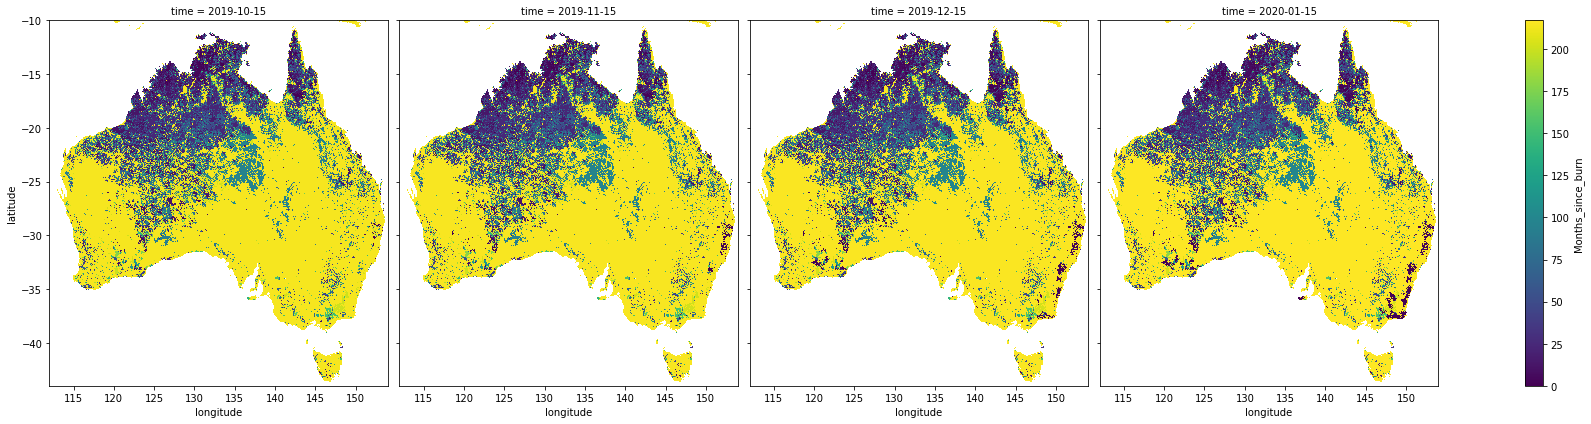

In [8]:
ds.isel(time=[213,214,215,216]).plot.imshow(size=6, col='time')

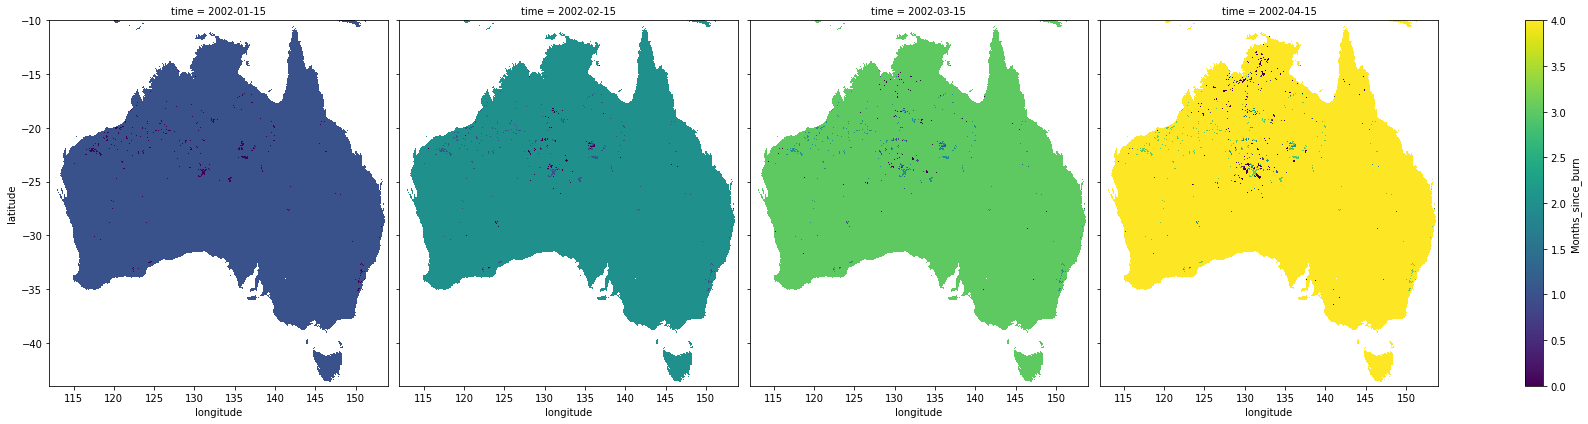

In [9]:
ds.isel(time=[0,1,2,3]).plot.imshow(size=6, col='time')

In [ ]:
del ds.attrs['crs']

In [ ]:
del ds.attrs['transform']

In [ ]:
ds.isel()

In [ ]:
ds = ds.rename({'Gpp':'GPP'})

In [ ]:
#compute climatology
clim = ds['NDWI'].chunk(dict(latitude=750, longitude=750))
clim = ds.groupby("time.month").mean("time").compute()

# fill nans with climatology and plot cloudiest period
ds = ds.groupby("time.month").fillna(clim).drop('month')

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/NDWI_1km_monthly_2002_2021.nc')

In [ ]:
evi = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/EVI_5km_monthly_2002_2021.nc').isel(time=0) #use this to reproject too
ds_rp = xr_reproject(ds, geobox=evi.geobox, resampling='average', dst_nodata=np.nan).compute() #reproject
ds_rp['latitude'] = ds_rp.latitude.astype('float32')
ds_rp['longitude'] = ds_rp.longitude.astype('float32')
ds_rp

In [ ]:
ds_rp.NDWI.isel(time=110).plot.imshow(size=6,vmax=0.2, vmin=-0.2, cmap='RdBu');

In [ ]:
ds.NDWI.isel(time=110).plot.imshow(size=6,vmax=0.2, vmin=-0.2, cmap='RdBu');

In [ ]:
ds.NDWI.groupby('time.month').mean().mean(['latitude','longitude']).plot(figsize=(11,5))

In [ ]:
ds_rp.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/5km/NDWI_5km_monthly_2002_2021.nc')